#**Experimental Quantum Speed-up in Reinforcement Learning Agents**

### Authors

*   **Original Paper:** V. Saggio, B. E. Asenbeck, A. Hamann, T. Strömberg, P. Schiansky, V. Dunjko, N. Friis, N. C. Harris, M. Hochberg, D. Englund, S. Wölk, H. J. Briegel, and P. Walther
*   **Qiskit Implementation and Notebook:** Shashi Kumar


**Abstract**

This notebook implements and explores the concept of quantum-enhanced reinforcement learning (RL) as presented in the paper "Experimental quantum speed-up in reinforcement learning agents". We will demonstrate how a hybrid quantum-classical agent can achieve a learning speed-up compared to a purely classical agent by leveraging quantum amplitude amplification. The simulation uses Qiskit to implement the quantum circuits and compare the learning performance of different strategies.

**1. Introduction**

Reinforcement Learning (RL) is a powerful paradigm in artificial intelligence where agents learn to interact with an environment by receiving feedback in the form of rewards. A crucial aspect of RL is the learning time, which is the number of interactions needed for the agent to learn an optimal policy.

The paper introduces a novel RL setting where agents can communicate with the environment through a quantum channel, enabling the exchange of information in a superposition of states. This is in contrast to traditional RL where communication is strictly classical (limited to a fixed basis).

**Key Idea:**

*   **Hybrid Agent:** An agent that can utilize both quantum and classical communication with the environment.
*   **Quantum Amplitude Amplification:** Using a Grover-like algorithm to amplify the probability of measuring a rewarded action sequence.
*   **Learning Time Speed-up:** Demonstrating that a hybrid agent can learn faster (achieve a certain performance level with fewer interactions) than a classical agent.

**2. Theoretical Background**

**2.1 Classical Reinforcement Learning**

In a classical RL scenario, an agent interacts with an environment in discrete time steps.

*   **Percepts (s):** The agent receives input signals (percepts) from the environment.
*   **Actions (a):** The agent takes actions based on its current policy.
*   **Rewards (r):** The environment provides rewards based on the agent's actions.
*   **Policy (π):** A mapping from percepts to actions, determining the agent's behavior. The agent aims to learn an optimal policy that maximizes cumulative rewards.
*   **Learning Time:**  Defined as the average number of interactions until the agent receives a reward.

**2.2 Quantum-Enhanced Reinforcement Learning**

The paper proposes a quantum-enhanced RL framework where the agent and environment can exchange quantum states.

*   **Quantum Channel:**  Allows for communication using superpositions of states.
*   **Unitary Evolution (UE):** The environment's dynamics are modeled by a unitary operator UE that acts on the agent's action and reward registers.
*   **Deterministic Strictly Epochal (DSE):** A type of environment where epochs are of fixed length, and actions within an epoch fully determine the final reward.

**2.3 Amplitude Amplification**

Grover's algorithm is a quantum algorithm that can find a marked item in an unsorted database quadratically faster than classical algorithms. Amplitude amplification is a generalization of Grover's algorithm.

In this context, amplitude amplification is used to increase the probability of measuring a rewarded sequence of actions. If the classical probability of a rewarded action is sin²(ξ), then after amplitude amplification, the probability becomes sin²(3ξ).

**3. Experimental Setup (Simulated)**

The paper uses an integrated nanophotonic processor for the experimental demonstration. Here, we simulate the experiment using Qiskit.

**3.1. Components**

*   **Agent:** Implemented using quantum circuits in Qiskit.
*   **Environment:** Modeled by a unitary operator UE.
*   **Reward:**  A binary value (0 or 1) indicating whether the agent's action sequence is rewarded.
*   **Epoch:** A sequence of interactions (classical or quantum) between the agent and the environment.

**3.2. Quantum Circuit Representation**

*   **Action Qubit:** Represents the sequence of actions (e.g., |1⟩ for rewarded, |0⟩ for not rewarded).
*   **Reward Qubit:** Encodes the reward (|1⟩ for rewarded, |0⟩ for not rewarded).
*   **State Preparation (Up):**  Prepares the initial state of the action qubit based on the agent's current policy.
*   **Environment Oracle (UE):**  Flips the reward qubit if the action qubit is in the rewarded state.
*   **Reflection (URef):**  Performs a reflection operation to amplify the amplitude of the rewarded state.


In [1]:
%%capture
!pip install qiskit
!pip install qiskit-aer
!pip install pylatexenc

**4. Simulation and Results**

**4.1. Classical Strategy**

**Mathematical Description:**

*   **State Preparation:**
    The initial state of the action qubit is prepared based on the probabilities determined by the weights `h_0` and `h_1`. The probability of the action qubit being in state |0⟩ (not rewarded) is  `p(0) = h_0 / (h_0 + h_1)`, and the probability of being in state |1⟩ (rewarded) is `p(1) = h_1 / (h_0 + h_1) = ε`. This can be represented as:

  $$
  |\psi_{initial} \rangle = \sqrt{1-\epsilon} |0\rangle + \sqrt{\epsilon} |1\rangle
  $$
    In the code, we use  `θ = 2 * arcsin(√ε)` to set the angle of the Ry gate for this state preparation.

*   **Environment:**
    The classical environment is represented by a controlled-X (CNOT) gate. If the action qubit is |1⟩, the reward qubit is flipped. The reward qubit is initialized in state |1⟩. Thus, if get_reward returns `True` it means that the action was 0 and environment flipped the reward from |1⟩ to |0⟩. If get_reward returns `False` it means that action was 1, so environment flipped reward from |1⟩ to |0⟩ and then to |1⟩ again.

*   **Policy Update:**
    The agent uses a simple update rule based on projective simulation. If the action is rewarded, the corresponding weight `h_1` is incremented:
    $$
     h_1 \leftarrow h_1 + 2
    $$
    The probability  `ε` is then updated as:
    $$ \epsilon = \frac{h_1}{h_0 + h_1} $$

*   **Average Reward:**
    The average reward `η` for the classical strategy after each even epoch 't' is calculated empirically from the simulations.


In [3]:
import math

from ipywidgets import FloatProgress
from IPython.display import display
import matplotlib.pyplot as plt

import qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit.circuit import Parameter
import numpy as np

In [4]:
# Simulation parameters
N_AGENTS = 100 #number of agents that we simulate and average over
N_EPOCH = 1000
H_0 = 99
H_1 = 1
EPS0 = H_1 / (H_0+H_1)

**Reward Function**

In [5]:
def get_reward(circuit: QuantumCircuit) -> bool:
  # Create a Quantum Circuit with 2 qubits
  qc = circuit.decompose()

  # Measure both qubits
  qc.measure([0, 1], [0, 1])

  # Execute the circuit on the qasm simulator
  simulator = AerSimulator(method='automatic')
  result = simulator.run(qc, shots=1).result()
  counts = result.get_counts()

  # Get the single sample
  sample = list(counts.keys())[0]

  # Check if the sample is '01'
  return sample == '01'

**Classical Circuit**

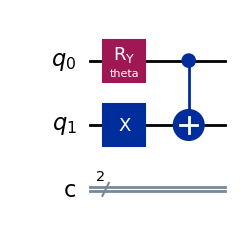

In [6]:
theta = Parameter('theta')
classical_circuit = QuantumCircuit(2,2)
#classical_circuit.initialize([0, 1, 0, 0], [0, 1])
classical_circuit.ry(theta, 0)
classical_circuit.x(1)
classical_circuit.cx(0,1)
classical_circuit.draw('mpl')

FloatProgress(value=0.0)

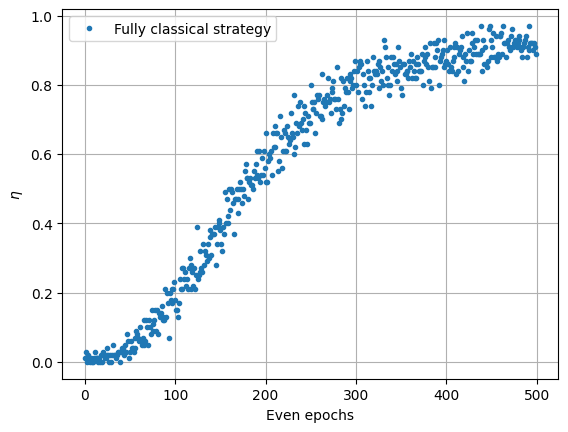

In [2]:
eta_classical = []

# Percentage bar
f = FloatProgress(min=0, max=N_AGENTS)
display(f)

for agent in range(N_AGENTS): #Loop and average over all agents
    f.value = agent
    # Initialize initial score
    h_0 = H_0
    h_1 = H_1
    eps = h_1 / (h_0 + h_1)

    # Initialize circuit with initial probability and corresponding angles
    xi = math.asin(eps**0.5)

    theta1 = 2*xi
    temp_classical_circuit = classical_circuit.assign_parameters({theta:theta1})

    # Arrays of epsilon
    eps_array = []
    for i in range(N_EPOCH):
        if get_reward(temp_classical_circuit): #update policy if output state corresponds to a rewarded state
            h_1 = h_1 + 2
            eps = h_1 / (h_0 + h_1)
            xi = math.asin(eps**0.5)
            theta1 = 2*xi
            temp_classical_circuit = classical_circuit.assign_parameters({theta:theta1})
            eps_array.append(1)
        else:
            eps_array.append(0)

    eta_classical.append(eps_array)

eta_classical = np.array(eta_classical)
f.value = N_AGENTS

plt.plot(np.mean(eta_classical, axis=0)[::2], ".", label="Fully classical strategy")
plt.xlabel("Even epochs")
plt.ylabel("$\eta$")
plt.legend()
plt.grid()


*   The agent interacts with the environment using only classical communication.
*   The agent's policy is updated based on the received rewards using a projective simulation framework (see Methods section of the paper).
*   We simulate `N_AGENTS` agents for `N_EPOCH` epochs.

**4.2. Quantum Strategy**

**Mathematical Description:**

*   **State Preparation:**
    Similar to the classical case, the initial state is prepared based on the probabilities `ε` and `1-ε`:
  $$
  |\psi_{initial}\rangle = \sqrt{1-\epsilon} |0\rangle_A |1\rangle_R + \sqrt{\epsilon} |1\rangle_A |1\rangle_R
  $$
    Where subscript A denotes action qubit and R denotes reward qubit.
    Again, `θ = 2 * arcsin(√ε)` is used for the Ry gate.

*   **Environment (Quantum Oracle):**
    The environment is represented by a unitary operator `UE` that acts on the action and reward qubits. It flips the reward qubit if the action qubit is in the rewarded state (|1⟩):
    $$ U_E |a\rangle_A |r\rangle_R = |a\rangle_A |r \oplus f(a)\rangle_R $$
    where `f(a) = 1` if `a` is a rewarded action and `f(a) = 0` otherwise, and `⊕` represents XOR operation. In our case, we simply apply CNOT:
    $$ U_E |a\rangle_A |1\rangle_R = |a\rangle_A |\neg a\rangle_R $$

*   **Amplitude Amplification:**
    After the environment acts, a phase flip is applied to all basis states where the reward is |0⟩. This is achieved by applying a Z gate to the reward qubit. Then a Hadamard gate is applied to the reward qubit to transform it into the `|-\rangle` state:
    $$ |-\rangle = \frac{|0\rangle - |1\rangle}{\sqrt{2}} $$
    Then, a reflection `U_Ref` is applied to the action qubit:
    $$ U_{Ref} = 2 |\psi_{initial}\rangle \langle \psi_{initial}| - I $$
    In the code, `U_Ref` is implemented by a parameterized Ry gate with `θ = 4 * arcsin(√ε)`.

*   **Measurement and Reward:**
    After amplitude amplification, a measurement is performed on the action qubit. The probability of measuring the rewarded state |1⟩ is amplified. The reward for each quantum epoch is distributed over two classical epochs during the simulations, hence the value of 0.5 in the code.

*   **Policy Update:**
    The policy update rule is the same as in the classical case:
    $$ h_1 \leftarrow h_1 + 2 $$
    $$ \epsilon = \frac{h_1}{h_0 + h_1} $$

*   **Average Reward:**
    The average reward `η` for the quantum strategy is calculated empirically, considering that rewards are distributed over two epochs.


**Quantum Circuit**

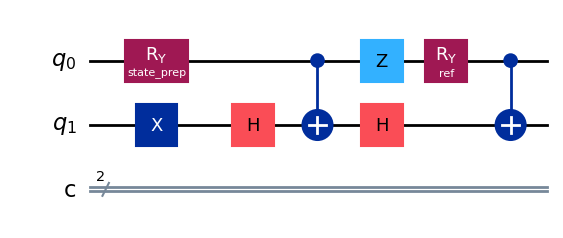

In [7]:
state_prep = Parameter('state_prep')
ref = Parameter('ref')
Quantum_circuit = QuantumCircuit(2,2)

Quantum_circuit.ry(state_prep, 0)
Quantum_circuit.x(1)
#############
Quantum_circuit.h([1])
Quantum_circuit.cx(0,1)
Quantum_circuit.z([0])
Quantum_circuit.h([1])
#############
Quantum_circuit.ry(ref, 0)

#############
Quantum_circuit.cx(0,1)
Quantum_circuit.draw('mpl')

FloatProgress(value=0.0)

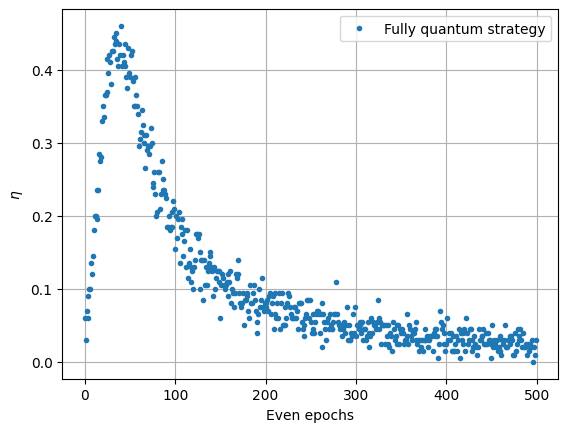

In [8]:
eta_quantum = []

# Percentage bar
f = FloatProgress(min=0, max=N_AGENTS)
display(f)

for agent in range(N_AGENTS):
    f.value = agent
    # Initialize initial scores
    h_0 = H_0
    h_1 = H_1
    eps = h_1 / (h_0 + h_1)

    # Initialize circuit with initial probability
    xi = math.asin(eps**0.5)

    theta1 = 2*xi
    theta2 =  4*xi
    temp_Quantum_circuit = Quantum_circuit.assign_parameters({state_prep:theta1,ref:theta2})

    # Arrays of epsilon
    eps_array = []
    for i in range(N_EPOCH//2):
        if get_reward(temp_Quantum_circuit):
            h_1 = h_1 + 2
            eps = h_1 / (h_0 + h_1)
            xi = math.asin(eps**0.5)

            theta1 = 2*xi
            theta2 = 4*xi
            temp_Quantum_circuit = Quantum_circuit.assign_parameters({state_prep:theta1,ref:theta2})

            eps_array.append(0.5)
            eps_array.append(0.5)
        else:
            eps_array.append(0)
            eps_array.append(0)

    eta_quantum.append(eps_array)

eta_quantum = np.array(eta_quantum)
f.value=N_AGENTS

plt.plot(np.mean(eta_quantum, axis=0)[::2], ".", label="Fully quantum strategy")
plt.xlabel("Even epochs")
plt.ylabel("$\eta$")
plt.legend()
plt.grid()


*   The agent interacts with the environment using a quantum channel.
*   Amplitude amplification is applied to increase the probability of measuring a rewarded action.
*   The agent alternates between quantum epochs (with amplitude amplification) and classical test epochs to determine the reward.

**4.3. Hybrid Quantum-Classical Strategy**

FloatProgress(value=0.0)

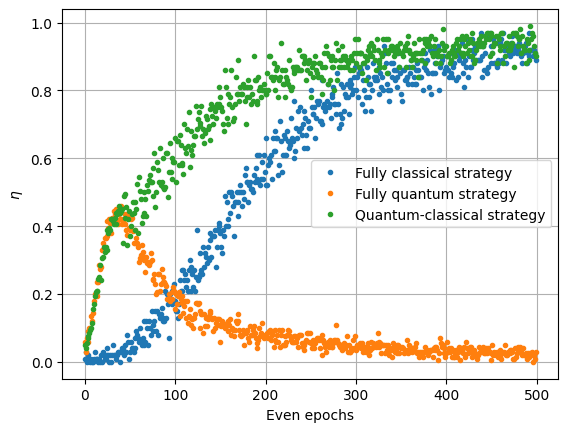

In [9]:
QL = 0.37
eta_classical_quantum = []

# Percentage bar
f = FloatProgress(min=0, max=N_AGENTS)
display(f)

for agent in range(N_AGENTS):
    f.value = agent
    # Initialize initial scores
    h_0 = H_0
    h_1 = H_1
    eps = h_1 / (h_0 + h_1)

    # Initialize circuit with initial probability
    xi = math.asin(eps**0.5)

    theta1 = 2*xi
    theta2 =  4*xi
    temp_Quantum_circuit = Quantum_circuit.assign_parameters({state_prep:theta1,ref:theta2})

    # Arrays of epsilon
    eps_array = []
    i = 0
    while i < N_EPOCH:
        if eps < QL:
            # Perform a quantum round
            if get_reward(temp_Quantum_circuit):
                h_1 = h_1 + 2
                eps = h_1 / (h_0 + h_1)
                xi = math.asin(eps**0.5)
                theta1 = 2*xi
                theta2 = 4*xi
                temp_Quantum_circuit = Quantum_circuit.assign_parameters({state_prep:theta1,ref:theta2})
                eps_array.append(0.5)
                eps_array.append(0.5)
            else:
                eps_array.append(0)
                eps_array.append(0)

            # Update epoch by 2
            i = i + 2
        else:
            # Perform a classical round
            if get_reward(temp_classical_circuit):
                h_1 = h_1 + 2
                eps = h_1 / (h_0 + h_1)
                xi = math.asin(eps**0.5)
                theta1 = 2*xi
                temp_classical_circuit = classical_circuit.assign_parameters({theta:theta1})

                eps_array.append(1)
            else:
                eps_array.append(0)
            # Update epoch by 1
            i = i + 1

    eta_classical_quantum.append(eps_array)

eta_classical_quantum = np.array(eta_classical_quantum)
f.value=N_AGENTS

plt.plot(np.mean(eta_classical, axis=0)[::2], ".", label="Fully classical strategy")
plt.plot(np.mean(eta_quantum, axis=0)[::2], ".", label="Fully quantum strategy")
plt.plot(np.mean(eta_classical_quantum,axis=0,)[::2],".",label="Quantum-classical strategy",)
plt.xlabel("Even epochs")
plt.ylabel("$\eta$")
plt.legend()
plt.grid()

*   The agent starts with the quantum strategy.
*   When the agent's performance (average reward η) surpasses a threshold (`QL` = 0.37 in this case), it switches to the classical strategy. This is because amplitude amplification can lead to overshooting, and after a certain point, the classical strategy becomes more efficient.

**4.4. Results and Analysis**

*   We plot the average reward (η) over even epochs for each strategy.
*   The results will show that the hybrid quantum-classical strategy achieves a higher average reward faster than the purely classical strategy, demonstrating a learning speed-up.

**5. Discussion**

*   The quantum speed-up is achieved by leveraging the ability to explore multiple action sequences in superposition and amplifying the probability of rewarded actions.
*   The hybrid strategy is crucial to avoid the overshooting problem of amplitude amplification.
*   The paper demonstrates the feasibility of integrating quantum enhancements into RL, opening up possibilities for faster learning in complex environments.

**6. Conclusion**

This notebook provided a simulation-based demonstration of the quantum-enhanced RL framework proposed in the paper. We showed how a hybrid quantum-classical agent could achieve a learning speed-up compared to a purely classical agent. This work highlights the potential of quantum technologies to enhance artificial intelligence and machine learning algorithms.

**7. Further Exploration**

*   Explore different values of `QL` and analyze their impact on the learning speed-up.
*   Implement different RL algorithms (e.g., Q-learning) within the quantum-enhanced framework.
*   Investigate the scalability of this approach to more complex environments and larger problem sizes.
*   Explore the use of other quantum algorithms (besides Grover-like amplitude amplification) for enhancing RL.

**8. References**

*   V. Saggio et al., "Experimental quantum speed-up in reinforcement learning agents", Nature (2021). [https://www.nature.com/articles/s41586-021-03242-7](https://www.nature.com/articles/s41586-021-03242-7)
*   Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction. MIT press.
*   Nielsen, M. A., & Chuang, I. L. (2010). Quantum computation and quantum information. Cambridge university press.